<h1>Práctica Final de Spark - 1. Modelo de Machine Learning</h1>
<p/>
<table border>
<tr><td>Alumno</td><td>email</td><td>Teléfono</td></ur>
<tr><td>José María Álvarez</td><td>josemaria.alvarezfernandez@elcorteingles.es</td><td>+34 682 780 953</td></ur>
<tr><td>Adolfo González</td><td>adolfo.gonzalez@elcorteingles.es</td><td>+34 609 964 414</td></ur>
<tr><td>César Colado</td><td>cesar.colado@elcorteingles.es</td><td>+34 661 415 555</td></ur>
</table>

## KMeans con un dataset de vinos

El objetivo será generar un modelo de segmentación, que nos permita agrupar los vinos que nos van llegando a un congreso de vinos. La cantidad de vinos que llegan de cada uno de los fabricantes, nos podría obligar a ir sometiendo cada vino al modelo diseñado y solicitar al productor la exposición de sus vinos en las categorías que se le asignen.
 
Para hacer esto, modelaremos la llegada de la información de cada vino mediante un “streaming” que hemos realizado en un script en python. 


Primero cargamos el dataset. El dataset se encuentra en los repositorios de UCI machine learning. Para ello aprovechamos y lo cargamos desde una URL con los métodos de Pandas (ya que Spark no lo permite) y lo mostramos.

In [9]:
import pandas as pd
pd_df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", header=0, delimiter=";")
pd_df['id'] = 'wine'+pd_df.index.astype(str)
wineDF = spark.createDataFrame(pd_df)
wineDF.show()

+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+------+
|fixed acidity|volatile acidity|citric acid|residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|    id|
+-------------+----------------+-----------+--------------+-------------------+-------------------+--------------------+-------+----+---------+-------+-------+------+
|          7.4|             0.7|        0.0|           1.9|              0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5| wine0|
|          7.8|            0.88|        0.0|           2.6|              0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5| wine1|
|          7.8|            0.76|       0.04|           2.3|              0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5| wine2

Comprobamos que todas las columnas que nos interesan para el agrupamiento son del tipo numérico. Existe una columna denominada "quality" que si quisiéramos hacer un modelo de clasificación tendría sentido extraer como variable objetivo, pero dado que lo que queremos hacer es un algoritmo de clustering, veremos si la calidad afecta a los grupos o no como curiosidad. En nuestro caso la eliminaremos puesto que no se trata de una variable objetiva del vino y la dejaremos para ver si los grupos que se identifiquen se pueden asociar de alguna forma a la calidad, aunque no tendría porqué.

In [13]:
types = [element.dataType for element in wineDF.schema.fields]
print(types)
names = []
for element in wineDF.schema.fields:
    if element.name != "id":
        if element.name != "quality":
            names.append(element.name)
print(names)
wineDF = wineDF.na.drop()

[DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, DoubleType, LongType, StringType]
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [14]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=names, outputCol="features")
wineDF_kmeans = vecAssembler.transform(wineDF).select('id', 'features')
wineDF_kmeans.show()

+------+--------------------+
|    id|            features|
+------+--------------------+
| wine0|[7.4,0.7,0.0,1.9,...|
| wine1|[7.8,0.88,0.0,2.6...|
| wine2|[7.8,0.76,0.04,2....|
| wine3|[11.2,0.28,0.56,1...|
| wine4|[7.4,0.7,0.0,1.9,...|
| wine5|[7.4,0.66,0.0,1.8...|
| wine6|[7.9,0.6,0.06,1.6...|
| wine7|[7.3,0.65,0.0,1.2...|
| wine8|[7.8,0.58,0.02,2....|
| wine9|[7.5,0.5,0.36,6.1...|
|wine10|[6.7,0.58,0.08,1....|
|wine11|[7.5,0.5,0.36,6.1...|
|wine12|[5.6,0.615,0.0,1....|
|wine13|[7.8,0.61,0.29,1....|
|wine14|[8.9,0.62,0.18,3....|
|wine15|[8.9,0.62,0.19,3....|
|wine16|[8.5,0.28,0.56,1....|
|wine17|[8.1,0.56,0.28,1....|
|wine18|[7.4,0.59,0.08,4....|
|wine19|[7.9,0.32,0.51,1....|
+------+--------------------+
only showing top 20 rows



Es importante saber antes de usar Kmeans, cuantas agrupaciones queremos realizar. Es por ello que intentamos, como se muestra en el ejemplo del enunciado, sacar un valor de K para el cual ya no se "maximize" la ganancia

In [15]:
import numpy as np
from pyspark.ml.clustering import KMeans
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(wineDF_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(wineDF_kmeans)

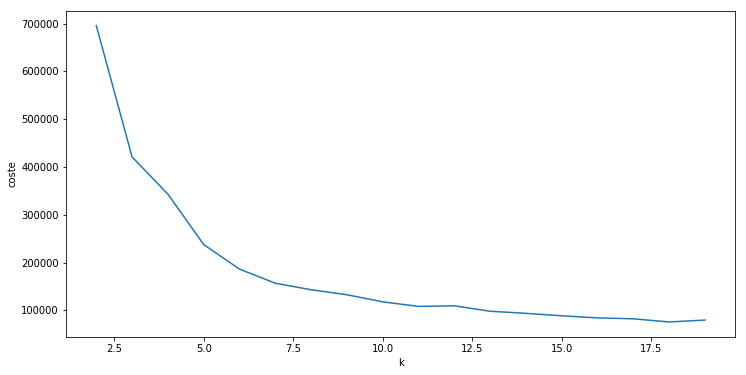

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize =(12,6))
ax.plot(range(2,20),cost[2:20])
_ = ax.set_xlabel('k')
_ = ax.set_ylabel('coste')

En principio vamos a intentar quedarnos con un K de 11, a partir del cual la ganacia es realmente pequeña, y sabiendo además que la calidad del vino se va a medir de 0 a 10

In [17]:
kmeans_k = 11
kmeans = KMeans().setK(kmeans_k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(wineDF_kmeans)

In [18]:
predictions = model.transform(wineDF_kmeans).select('id', 'prediction')
rows = predictions.collect()
print(rows[:3])

[Row(id='wine0', prediction=6), Row(id='wine1', prediction=0), Row(id='wine2', prediction=7)]


In [19]:
wineDF_pred = spark.createDataFrame(rows)
wineDF_pred.show()

+------+----------+
|    id|prediction|
+------+----------+
| wine0|         6|
| wine1|         0|
| wine2|         7|
| wine3|         7|
| wine4|         6|
| wine5|         4|
| wine6|         7|
| wine7|         6|
| wine8|         1|
| wine9|         8|
|wine10|         7|
|wine11|         8|
|wine12|         7|
|wine13|         6|
|wine14|         9|
|wine15|         9|
|wine16|        10|
|wine17|         7|
|wine18|         6|
|wine19|         7|
+------+----------+
only showing top 20 rows



Ahora salvamos el modelo

In [20]:
model.save("wine_kmeans_model")

Según la documentación y los ejemplos de Spark (https://github.com/apache/spark/blob/v2.2.1/examples/src/main/python/ml/kmeans_example.py), podemos evaluar el modelo, y así lo hacemos

In [21]:
# Evaluamos el clustering computando el "Within Set Sum of Squared Errors"
wssse = model.computeCost(wineDF_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 99494.80305208372


In [22]:
kmeans_k_2 = 6
kmeans2 = KMeans().setK(kmeans_k_2).setSeed(1).setFeaturesCol("features")
model2 = kmeans2.fit(wineDF_kmeans)

In [25]:
# Evaluamos el clustering computando el "Within Set Sum of Squared Errors"
wssse2 = model2.computeCost(wineDF_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse2))

Within Set Sum of Squared Errors = 193423.65775839088


In [37]:
kmeans_k_3 = 15
kmeans3 = KMeans().setK(kmeans_k_3).setSeed(1).setFeaturesCol("features")
model3 = kmeans3.fit(wineDF_kmeans)

In [38]:
# Evaluamos el clustering computando el "Within Set Sum of Squared Errors"
wssse3 = model3.computeCost(wineDF_kmeans)
print("Within Set Sum of Squared Errors = " + str(wssse3))

Within Set Sum of Squared Errors = 73612.36286295216


Como se puede observar, entendemos que estamos calculando la calidad del modelo valorando la distancia a los centroides de cada cluster. Como vemos cuantos más cluster generamos, reducimos las distancias y por tanto parece que se mejora el modelo. 

El compromiso lo tenemos en k=11, como hemos comentado anteriormente, que es donde encontramos la maximización del beneficio en añadir más clusters. 

En Spark 2.3 aparece disponible un "clustering evaluator" que no podemos utilizar, dado que este ejercicio lo estamos resolviendo con Spark 2.2.1

